# Sea-ice segmentation - ASSW Workshop

This repository contains code for the paper titled 'Supplementing remote sensing of ice: Deep learning-based image segmentation system for automatic detection and localization of sea-ice formations from close-range optical images'.

If you use this code, please cite:

> **N. Panchi, E. Kim and A. Bhattacharyya, "Supplementing remote sensing of ice: Deep learning-based image segmentation system for automatic detection and localization of sea ice formations from close-range optical images," in IEEE Sensors Journal, doi: 10.1109/JSEN.2021.3084556.**


In [1]:
#hide

#Auto-reload any changes made to external modules
%load_ext autoreload
%autoreload 2

#For matplotlib
%matplotlib inline

# Environment setup

Install fastai: 
- Create a new environment using anaconda
- Run: ```conda install -y -c fastchan fastai anaconda```

For more information: [link to installation guide](https://docs.fast.ai/#Installing)

If the installation is taking too long, install [mamba](https://github.com/mamba-org/mamba) and use that insted of conda. 

In [2]:
#Import the libraries

from fastai.vision.all import *

# Dataset

**Folder structure**

Create the following folder structure, in the same directory as this notebook

```
.
└── data
    └── images
    └── labels
    └── validation.txt
```

```images```: Contains all the images (.jpg).

```labels```: Contains all the labels (.png).


In [3]:
#Load the filepaths of the images
images = get_image_files('./data/images')

#Create a list of the labels using the image names
labels = [Path('./data/labels')/i.name.replace('.jpg', '_mask.png') for i in images]

#print the number of images and labels
print(len(images), len(labels))

#Create a dataframe with the filepaths of the images and the labels
df = pd.DataFrame({'image':images, 'label':labels})

df.head()

34 34


,image,label
0,data\images\floeberg1_floeice_4.jpg,data\labels\floeberg1_floeice_4_mask.png
1,data\images\floeberg3_floeice6.jpg,data\labels\floeberg3_floeice6_mask.png
2,data\images\floeberg4_floeice7.jpg,data\labels\floeberg4_floeice7_mask.png
3,data\images\floeberg_floeice3.jpg,data\labels\floeberg_floeice3_mask.png
4,data\images\floeice.jpg,data\labels\floeice_mask.png


In [4]:
#Create a new column, and assign 10% of the images to be the validation set
valid_idxs = np.random.choice(len(df), size=int(0.1*len(df)), replace=False)
df['is_valid'] = [(True if idx in valid_idxs else False) for idx in range(len(df))]

df['is_valid'].value_counts()

False    31
True      3
Name: is_valid, dtype: int64

In [5]:
#All the classes in our dataset
classes = ["Brash ice", "Deformed ice", "Floeberg", "Floebit", 
           "Ice floe", "Iceberg", "Level ice", "Melt pond", "Open water", 
           "Pancake ice", "Shore", "Sky", "Underwater ice"]

In [6]:
def get_data(df, img_size=(256, 256), batch_size=2, classes=classes):
    """Get the dataloaders"""

    db = DataBlock(blocks=(ImageBlock, MaskBlock(classes)),
                   get_x=ColReader('image'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter(col='is_valid'),
                   item_tfms=[Resize(img_size)],
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

    dls = db.dataloaders(df, bs=batch_size, tfm_y=True, num_workers=0)

    return dls


C:\Users\nabilpa\Anaconda3\envs\sea_ice_seg\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
C:\Users\nabilpa\Anaconda3\envs\sea_ice_seg\lib\site-packages\torch\_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replac

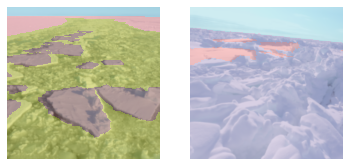

In [7]:
dls = get_data(df, img_size=(256, 256), batch_size=2, classes=classes)
dls.show_batch()

# Training

In [8]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(6)


epoch,train_loss,valid_loss,time


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.